# Least Core for Data Valuation

This notebook introduces Least Core methods for the computation of data values using pyDVL.

Shapley values define a fair way of distributing the worth of the whole training set when every data point is part of it. But they do not consider the question of stability of subsets: Could some data points obtain a higher payoff if they formed smaller subsets? It is argued that this might be relevant if data providers are paid based on data value, since Shapley values can incentivise them not to contribute their data to the "grand coalition", but instead try to form smaller ones. Whether this is of actual practical relevance is debatable, but in any case, the least core is an alternative tool available for any task of Data Valuation

The Core is another approach to compute data values originating in cooperative game theory that attempts to answer those questions. It is the set of feasible payoffs that cannot be improved upon by a coalition of the participants.

Its use for Data Valuation was first described in the paper [*If You Like Shapley Then You’ll Love the Core*](https://ojs.aaai.org/index.php/AAAI/article/view/16721) by Tom Yan and Ariel D. Procaccia.

The Least Core value $v$ of the $i$-th sample in dataset $D$ wrt. utility $u$ is computed
by solving the following Linear Program:

$$
\begin{array}{lll}
\text{minimize} & \displaystyle{e} & \\
\text{subject to} & \displaystyle\sum_{x_i\in D} v_u(x_i) = u(D) & \\
& \displaystyle\sum_{x_i\in S} v_u(x_i) + e \geq u(S) &, \forall S \subset D, S \neq \emptyset \\
\end{array}
$$

To illustrate this method we will use a synthetic dataset. We will first use a subset of 10 data point to compute the exact values and use them to assess the Monte Carlo approximation. Afterwards, we will conduct the data removal experiments as described by Ghorbani and Zou in their paper [Data Shapley: Equitable Valuation of Data for Machine Learning](https://arxiv.org/abs/1904.02868v1): We compute the data valuation given different computation budgets and incrementally remove a percentage of the best, respectively worst, data points and observe how that affects the utility.

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [16]:
%autoreload
%matplotlib inline

import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm, trange

warnings.simplefilter("ignore")

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

random_state = 16
random.seed(random_state)
np.random.seed(random_state)

is_CI = os.environ.get("CI")

dataset_size = 200
n_iterations = 5000
train_size = 10
n_jobs = 4

if is_CI:
    dataset_size = 20
    n_iterations = 500
    train_size = 0.2
    n_jobs = 1

We will be using the following functions and classes from pyDVL.

In [17]:
%autoreload
from pydvl.utils import (
    Dataset,
    Utility,
)
from pydvl.value import compute_least_core_values, LeastCoreMode, ValuationResult
from pydvl.reporting.plots import shaded_mean_std
from pydvl.reporting.scores import compute_removal_score

## Dataset

We generate a synthetic dataset using the [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function from scikit-learn.

We sample 200 data points from a 50-dimensional Gaussian distribution with 25 informative features and 25 non-informative features (generated as random linear combinations of the informative features).

The 200 samples are uniformly distributed across 3 classes with a small percentage of noise added to the labels to make the task a bit more difficult.

In [18]:
X, y = make_classification(
    n_samples=dataset_size,
    n_features=50,
    n_informative=25,
    n_classes=3,
    random_state=random_state,
)

In [19]:
full_dataset = Dataset.from_arrays(
    X, y, stratify_by_target=True, random_state=random_state
)
small_dataset = Dataset.from_arrays(
    X,
    y,
    stratify_by_target=True,
    train_size=train_size,
    random_state=random_state,
)

In [20]:
model = LogisticRegression(max_iter=500, solver="liblinear")

In [21]:
model.fit(full_dataset.x_train, full_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(full_dataset.x_train, full_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(full_dataset.x_test, full_dataset.y_test):0.2f}%"
)

Training accuracy: 100.00%
Testing accuracy: 25.00%


In [22]:
model.fit(small_dataset.x_train, small_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(small_dataset.x_train, small_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(small_dataset.x_test, small_dataset.y_test):0.2f}%"
)

Training accuracy: 100.00%
Testing accuracy: 37.50%


## Estimating Least Core Values

In this first section we will use a smaller subset of the dataset containing 10 samples in order to be able to compute exact values in a reasonable amount of time. Afterwards, we will use the Monte Carlo method with a limited budget (maximum number of subsets) to approximate these values.

In [23]:
utility = Utility(model=model, data=small_dataset)

In [24]:
exact_values = compute_least_core_values(
    u=utility,
    mode=LeastCoreMode.Exact,
    progress=True,
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [25]:
exact_values_df = exact_values.to_dataframe(column="exact_value").T
exact_values_df = exact_values_df[sorted(exact_values_df.columns)]

In [34]:
budget_array = np.linspace(200, 2 ** len(small_dataset), num=10, dtype=int)

all_estimated_values_df = []
all_errors = {budget: [] for budget in budget_array}

for budget in tqdm(budget_array):
    dfs = []
    errors = []
    column_name = f"estimated_value_{budget}"
    for i in range(20):
        values = np.array([np.nan], dtype=float)
        values = compute_least_core_values(
            u=utility,
            mode=LeastCoreMode.MonteCarlo,
            n_iterations=budget,
            n_jobs=n_jobs,
        )
        df = (
            values.to_dataframe(column=column_name)
            .drop(columns=[f"{column_name}_stderr"])
            .T
        )
        df = df[sorted(df.columns)]
        error = mean_squared_error(
            exact_values_df.loc["exact_value"].values, np.nan_to_num(df.values.ravel())
        )
        all_errors[budget].append(error)
        df["budget"] = budget
        dfs.append(df)
    estimated_values_df = pd.concat(dfs)
    all_estimated_values_df.append(estimated_values_df)

values_df = pd.concat(all_estimated_values_df)
errors_df = pd.DataFrame(all_errors)

  0%|          | 0/10 [00:00<?, ?it/s]

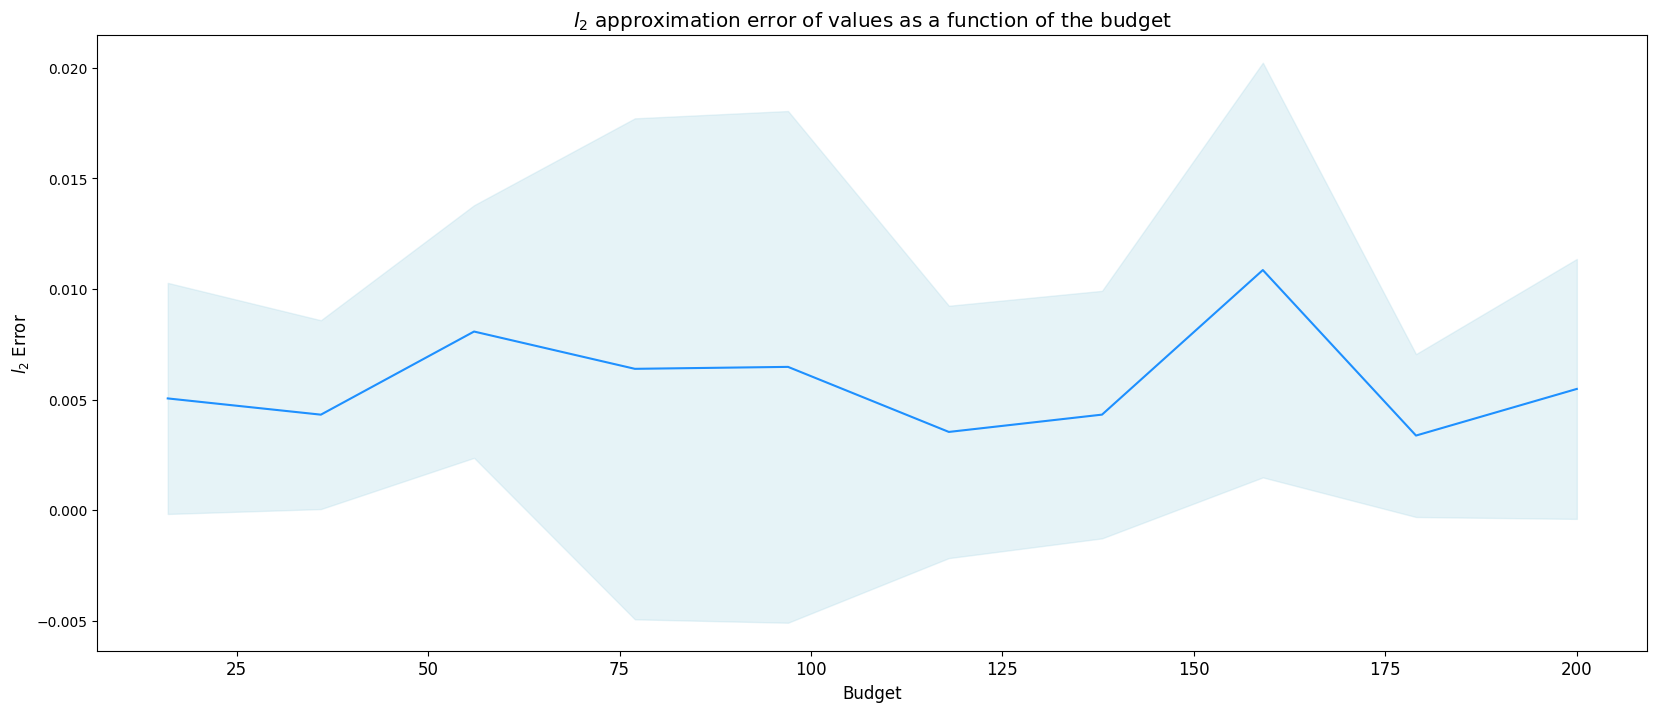

In [28]:
_ = shaded_mean_std(
    errors_df,
    abscissa=errors_df.columns,
    num_std=1,
    xlabel="Budget",
    ylabel="$l_2$ Error",
    label="Estimated values",
    title="$l_2$ approximation error of values as a function of the budget",
)
plt.show()

We can see that the approximation error decreases, on average, as the we increase the budget. 

Still, the decrease may not always necessarily happen when we increase the number of iterations because of the fact that we sample the subsets with replacement in the Monte Carlo method i.e there may be repeated subsets.

In [ ]:
mean_std_values_df = values_df.drop(columns="budget").agg(["mean", "std"])
df = pd.concat([exact_values_df, mean_std_values_df])
df = df.sort_values("exact_value", ascending=False, axis=1).T
df.plot(
    kind="bar",
    title="Comparison of Exact and Monte Carlo Methods",
    xlabel="Index",
    ylabel="Value",
    color=["dodgerblue", "indianred"],
    y=["exact_value", "mean"],
    yerr=[exact_values_df.loc["exact_value_stderr"], mean_std_values_df.loc["std"]],
)
plt.legend(["Exact", "Monte Carlo"])
plt.show()

## Data Removal

We now move on to the data removal experiments using the full dataset.

In these experiments, we first rank the data points from most valuable 
to least valuable using the values estimated by the Monte Carlo Least Core method.
Then, we gradually remove from 5 to 40 percent, by increments of 5 percentage points, of the most valuable/least valuable ones, train the model on this subset and compute its accuracy.

In [ ]:
utility = Utility(model=model, data=full_dataset)

In [ ]:
method_names = ["Random", "Least Core"]
removal_percentages = np.arange(0, 0.41, 0.05)

### Remove Best

We start by removing the best data points and seeing how the model's accuracy evolves.

In [ ]:
all_scores = []

for i in trange(5):
    for method_name in method_names:
        if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
        else:
            values = compute_least_core_values(
                u=utility,
                mode=LeastCoreMode.MonteCarlo,
                n_iterations=n_iterations,
                n_jobs=n_jobs,
            )
        scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=True,
        )
        scores["method_name"] = method_name
        all_scores.append(scores)

scores_df = pd.DataFrame(all_scores)

In [ ]:
fig, ax = plt.subplots()

for i, method_name in enumerate(method_names):
    shaded_mean_std(
        scores_df[scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage Removal",
        ylabel="Accuracy",
        label=method_name,
        title="Accuracy as a function of percentage of removed best data points",
        ax=ax,
    )
plt.legend()
plt.show()

We can clearly see that removing the most valuable data points, as given by the Least Core method, leads to, on average, a decrease in the model's performance and that the method outperforms random removal of data points.

### Remove Worst

We then proceed to removing the worst data points and seeing how the model's accuracy evolves.

In [ ]:
all_scores = []

for i in trange(5):
    for method_name in method_names:
        if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
        else:
            values = compute_least_core_values(
                u=utility,
                mode=LeastCoreMode.MonteCarlo,
                n_iterations=n_iterations,
                n_jobs=n_jobs,
            )
        scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
        )
        scores["method_name"] = method_name
        all_scores.append(scores)

scores_df = pd.DataFrame(all_scores)

In [ ]:
fig, ax = plt.subplots()

for i, method_name in enumerate(method_names):
    shaded_mean_std(
        scores_df[scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage Removal",
        ylabel="Accuracy",
        label=method_name,
        title="Accuracy as a function of percentage of removed worst data points",
        ax=ax,
    )
plt.legend()
plt.show()

We can clearly see that removing the least valuable data points, as given by the Least Core method, leads to, on average, an increase in the model's performance and that the method outperforms the random removal of data points.